# 5. Splittings to CO$_2$ density, to Pressure, to Depth (+MC)
- Once you have your corrected splittings from step 1-4, you need to convert them into a densimeter developed for your instrument
- If you have a densimeter, you can either contact me and I can add it to the function, or you can write your own function using our function as a template
- Data is here: https://github.com/PennyWieser/DiadFit/blob/main/docs/Examples/Example1b_CO2_Fluid_Inclusions/Calibration_fitting_w_sec_phases.xlsx

In [17]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import DiadFit as pf
pf.__version__

'0.0.51'

## Read in data

In [18]:
df=pd.read_excel('Calibration_fitting_w_sec_phases.xlsx')
df.head()

,Unnamed: 0.1,Unnamed: 0,Corrected_Splitting,filename_x,Splitting,Diad1_Combofit_Cent,Diad1_Combofit_Height,Diad1_Voigt_Cent,Diad1_Voigt_Area,Diad1_Voigt_Sigma,...,sec since midnight,Spectral Center,Ne_Correction,filename,Peak_Cent_SO2,Peak_Area_SO2,Peak_Height_SO2,Peak_Cent_Carb,Peak_Area_Carb,Peak_Height_Carb
0,0,0,102.835198,K21-59-FI#1,103.057281,1286.036078,590.183478,1286.036078,599.338630,0.435211,...,43795,1325.004,0.997845,K21-59-FI#1.txt,1151.160659,57.033468,26.540273,NaN,NaN,NaN
1,1,0,102.787877,K21-59-FI#2,103.010651,1286.157501,227.288998,1286.157501,200.266823,0.409698,...,44393,1325.004,0.997837,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2,0,102.822390,K21-59-FI#3,103.046189,1286.074236,570.010451,1286.074236,580.897805,0.422397,...,45146,1325.004,0.997828,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,3,0,103.085194,K21-61-FI#1-rep1,103.310515,1285.431591,65.483825,1285.431591,81.303002,0.574737,...,45944,1325.004,0.997819,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,4,0,103.078944,K21-61-FI#1-rep2,103.304596,1285.435781,607.688675,1285.435781,895.513299,0.568316,...,46247,1325.004,0.997816,K21-61-FI#1-rep2.txt,NaN,NaN,NaN,1090.889671,868.254585,43.035082


## Convert splitting to density
- Here we use the Cornell densimeter developed by DeVitre et al. (2021), and use the supercritical arguement, as analyses were done at 37C. 

In [19]:
densities=pf.calculate_density_cornell(temp='SupCrit', Split=df['Corrected_Splitting'])
densities.head()

,Preferred D,in range,Notes,LowD_RT,HighD_RT,LowD_SC,MedD_SC,HighD_SC,Temperature,Splitting,Preferred_D
0,0.043246,Y,"SupCrit, low density",0.037730,-0.391881,0.043246,0.045915,-0.363739,SupCrit,102.835198,NaN
1,0.025451,Y,"SupCrit, low density",0.020067,-0.436539,0.025451,0.029686,-0.408497,SupCrit,102.787877,NaN
2,0.038429,Y,"SupCrit, low density",0.032949,-0.403904,0.038429,0.041483,-0.375786,SupCrit,102.822390,NaN
3,0.137255,Y,"SupCrit, low density",0.131043,-0.166812,0.137255,0.137898,-0.138542,SupCrit,103.085194,NaN
4,0.134905,Y,"SupCrit, low density",0.128710,-0.172216,0.134905,0.135479,-0.143941,SupCrit,103.078944,NaN


## Calculate pressures using different equation of states and entrapment temps

### Using Span and Wanger, 1996 at 1150C

In [20]:
Pressure_SW96=pf.calculate_P_for_rho_T(T_K=1150+273.15,
                CO2_dens_gcm3=densities['Preferred D'],
                 EOS='SW96')
Pressure_SW96.head()

,P_kbar,P_MPa,T_K,CO2_dens_gcm3
0,0.119563,11.956315,1423.15,0.043246
1,0.069550,6.954958,1423.15,0.025451
2,0.105910,10.590985,1423.15,0.038429
3,0.405314,40.531364,1423.15,0.137255
4,0.397680,39.768006,1423.15,0.134905


### Using Sterner and Pitzer, 1994 at 1150 C

In [21]:
Pressure_SP94=pf.calculate_P_for_rho_T(T_K=1150+273.15,
                CO2_dens_gcm3=densities['Preferred D'],
                 EOS='SP94')
Pressure_SP94.head()

,P_kbar,P_MPa,T_K,CO2_dens_gcm3
0,0.119236,11.923582,1423.15,0.043246
1,0.069439,6.943860,1423.15,0.025451
2,0.105651,10.565070,1423.15,0.038429
3,0.403752,40.375155,1423.15,0.137255
4,0.396111,39.611056,1423.15,0.134905


## Lets convert these into depths in the crust
- DiadFit has various options for calculating depth, using the function 'convert_pressure_to_depth' 
1. Constant density
2. two-step density profile
3. three-step density profile
4. Crustal density models: 'ryan_lerner', 'mavko_debari', 'hill_zucca', 'prezzi,'rasmussen'

### We can compare the different options for converting density to depth here

In [22]:
# Make an array of pressures that is equally spaced from surface down to Moho
P_kbar_lin=np.linspace(0, 10, 100)

Depth_2700=pf.convert_pressure_to_depth(P_kbar=P_kbar_lin,
                crust_dens_kgm3=2700)

Depth_ryan_lerner=pf.convert_pressure_to_depth(P_kbar=P_kbar_lin,
                model='ryan_lerner')

Depth_Ramussen=pf.convert_pressure_to_depth(P_kbar=P_kbar_lin,
                model='rasmussen')

Depth_HZ=pf.convert_pressure_to_depth(P_kbar=P_kbar_lin,
                model='hill_zucca')

Depth_MD=pf.convert_pressure_to_depth(P_kbar=P_kbar_lin,
                model='mavko_debari')

Depth_prezzi=pf.convert_pressure_to_depth(P_kbar=P_kbar_lin,
                model='prezzi')

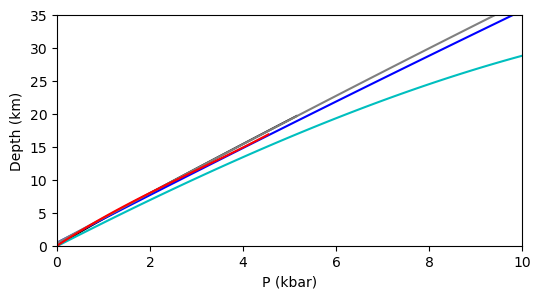

In [23]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6,3), sharey=True)

ax1.plot(P_kbar_lin, Depth_Ramussen, '-k')
ax1.plot(P_kbar_lin, Depth_HZ, '-c')
ax1.plot(P_kbar_lin, Depth_MD, '-b')
ax1.plot(P_kbar_lin, Depth_prezzi, '-', color='grey')
ax1.plot(P_kbar_lin, Depth_ryan_lerner, '-r')
ax1.set_xlim([0, 10])
ax1.set_ylim([0, 35])
ax1.set_xlabel('P (kbar)')
ax1.set_ylabel('Depth (km)')
fig.savefig('Diff_Profiles.png', dpi=300, bbox_inches='tight')

#### Constant crustal density of 2700 kg/m3

In [24]:
Depth_constant_rho=pf.convert_pressure_to_depth(P_kbar=Pressure_SW96['P_kbar'],
                crust_dens_kgm3=2700)
# Lets append this onto the dataframe above
Pressure_SW96['Depth_km_constantrho']=Depth_constant_rho
Pressure_SW96.head()

,P_kbar,P_MPa,T_K,CO2_dens_gcm3,Depth_km_constantrho
0,0.119563,11.956315,1423.15,0.043246,0.451403
1,0.069550,6.954958,1423.15,0.025451,0.262580
2,0.105910,10.590985,1423.15,0.038429,0.399856
3,0.405314,40.531364,1423.15,0.137255,1.530236
4,0.397680,39.768006,1423.15,0.134905,1.501416


#### Two-step density, 2800 kg/m3 above moho at 17km, 3100 kg/m3 below

In [25]:
Depth_two_step=pf.convert_pressure_to_depth(P_kbar=Pressure_SW96['P_kbar'],
                model='two-step', rho1=2800, rho2=3100, d1=17)
# Lets append this onto the dataframe above
Pressure_SW96['Depth_km_2step']=Depth_two_step
Pressure_SW96.head()

,P_kbar,P_MPa,T_K,CO2_dens_gcm3,Depth_km_constantrho,Depth_km_2step
0,0.119563,11.956315,1423.15,0.043246,0.451403,0.435282
1,0.069550,6.954958,1423.15,0.025451,0.262580,0.253202
2,0.105910,10.590985,1423.15,0.038429,0.399856,0.385575
3,0.405314,40.531364,1423.15,0.137255,1.530236,1.475585
4,0.397680,39.768006,1423.15,0.134905,1.501416,1.447794


#### Three step, 2400 kg/m3 down to 4km, 2800 down to 17 km, 3300 below that

In [26]:
Depth_three_step=pf.convert_pressure_to_depth(P_kbar=Pressure_SW96['P_kbar'],
model='three-step', rho1=2400, rho2=2800, rho3=3300, d1=4, d2=17)
# Lets append this onto the dataframe above
Pressure_SW96['Depth_km_3step']=Depth_three_step
Pressure_SW96.head()

,P_kbar,P_MPa,T_K,CO2_dens_gcm3,Depth_km_constantrho,Depth_km_2step,Depth_km_3step
0,0.119563,11.956315,1423.15,0.043246,0.451403,0.435282,0.507829
1,0.069550,6.954958,1423.15,0.025451,0.262580,0.253202,0.295403
2,0.105910,10.590985,1423.15,0.038429,0.399856,0.385575,0.449838
3,0.405314,40.531364,1423.15,0.137255,1.530236,1.475585,1.721516
4,0.397680,39.768006,1423.15,0.134905,1.501416,1.447794,1.689093


#### Using the density model of ryan-lerner. 

In [27]:
Depth_RL=pf.convert_pressure_to_depth(P_kbar=Pressure_SW96['P_kbar'],
model='ryan_lerner')
# Lets append this onto the dataframe above
Pressure_SW96['Depth_km_RL']=Depth_RL
Pressure_SW96.head()

,P_kbar,P_MPa,T_K,CO2_dens_gcm3,Depth_km_constantrho,Depth_km_2step,Depth_km_3step,Depth_km_RL
0,0.119563,11.956315,1423.15,0.043246,0.451403,0.435282,0.507829,0.550352
1,0.069550,6.954958,1423.15,0.025451,0.262580,0.253202,0.295403,0.321552
2,0.105910,10.590985,1423.15,0.038429,0.399856,0.385575,0.449838,0.488091
3,0.405314,40.531364,1423.15,0.137255,1.530236,1.475585,1.721516,1.820375
4,0.397680,39.768006,1423.15,0.134905,1.501416,1.447794,1.689093,1.787239


## Lets plot some of these depths and pressures
- We can make use of double axes to show pressure and depth for a given density model

Text(0, 0.5, '# of measurements')

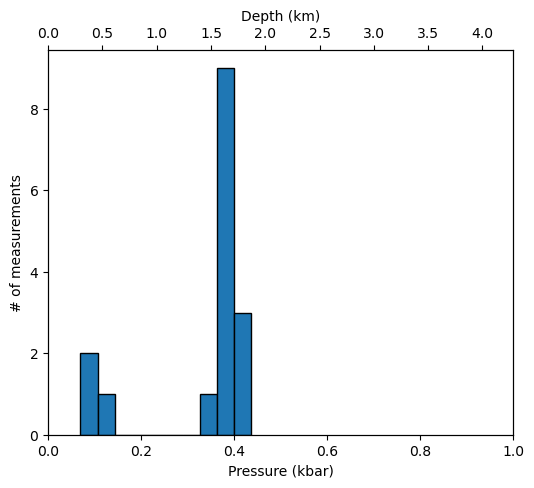

In [28]:
fig, (ax1) = plt.subplots(1, 1, figsize=(6,5))
# ax1 is your primary axis, lets say this is pressure.
ax1.hist(Pressure_SW96['P_kbar'], ec='k')
# Set your pressure limits for x
Plim1=0
Plim2=1
ax1.set_xlim([Plim1, Plim2])

# now lets duplicate the x axis, so we can show depth at the top
ax2=ax1.twiny()


D_P1=pf.convert_pressure_to_depth(P_kbar=Plim1,model='ryan_lerner')
D_P2=pf.convert_pressure_to_depth(P_kbar=Plim2,model='ryan_lerner')
ax2.set_xlim([D_P1[0], D_P2[0]])
ax1.set_xlabel('Pressure (kbar)')
ax2.set_xlabel('Depth (km)')
ax1.set_ylabel('# of measurements')

## Propagating errors in calculated pressure
- The main source of random error are the CO$_2$ density and how well you have determined it using microthermometry or Raman spectroscopy
- Entrapment temp could be a random error, or systematic, depending on how well temperature is constrained in your system
- The crustal density and/or choice of density profile is more likely a systematic error. 

### Lets propagate uncertainty in just entrapment temperature to start with
- We say we have a +-50K absolute uncertainty in temperature, distributed normally
- An error of +-0.01 g/cm3 in density (also distributed normally)
- An error in crustal density of 100 kg/m3 around a fixed value of 2700 kg/m3
- This function returns the average of each simulation for default N=1000 simulations.
- It also returns a dataframe of all simulations (e.g. 1000*# of fluid inclusions)
- This function also shows the distribution for one fluid inclusion, here fig_i=0 means it plots the first one, you can change this. 

working on sample number 0


,Filename,CO2_dens_gcm3,SingleFI_D_km,SingleFI_P_kbar,Mean_MC_P_kbar,Med_MC_P_kbar,std_dev_MC_P_kbar,Mean_MC_D_km,Med_MC_D_km,std_dev_MC_D_km,error_T_K,error_CO2_dens_gcm3,error_crust_dens_kgm3,T_K,CO2_dens_gcm3_input,model,crust_dens_kgm3,EOS
0,K21-59-FI#1,0.043246,0.451403,0.119563,0.118288,0.118464,0.028841,0.447121,0.446956,0.110479,50,0.01,100.0,1423.15,0.043246,None,2700,SW96
1,K21-59-FI#2,0.025451,0.262580,0.069550,0.070104,0.069616,0.027361,0.264924,0.261496,0.103390,50,0.01,100.0,1423.15,0.025451,None,2700,SW96
2,K21-59-FI#3,0.038429,0.399856,0.105910,0.106478,0.106867,0.028198,0.403075,0.407285,0.107829,50,0.01,100.0,1423.15,0.038429,None,2700,SW96
3,K21-61-FI#1-rep1,0.137255,1.530236,0.405314,0.405421,0.404887,0.036651,1.531238,1.527324,0.149053,50,0.01,100.0,1423.15,0.137255,None,2700,SW96
4,K21-61-FI#1-rep2,0.134905,1.501416,0.397680,0.398596,0.399682,0.034864,1.503029,1.504377,0.142184,50,0.01,100.0,1423.15,0.134905,None,2700,SW96


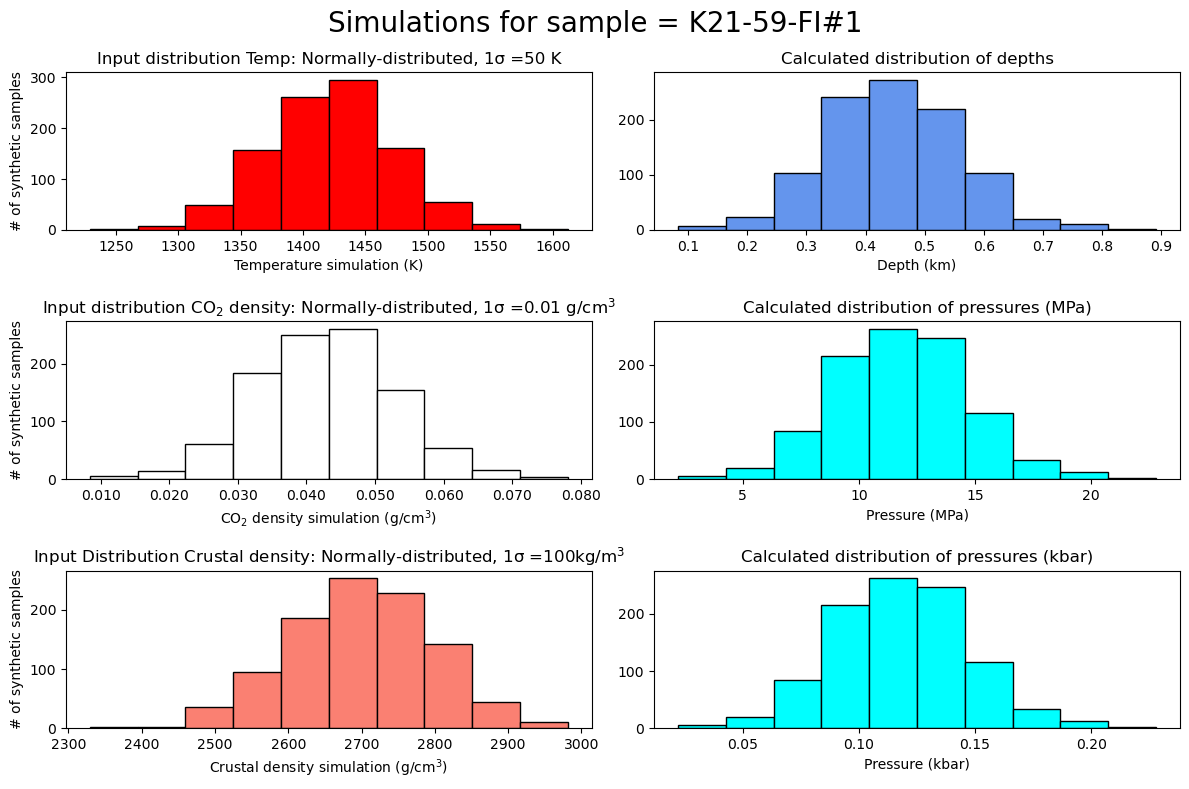

In [29]:
MC_Av_1, MC_All_1, fig=pf.propagate_FI_uncertainty(N_dup=1000,
sample_ID=df['filename_x'],
CO2_dens_gcm3=densities['Preferred D'], error_CO2_dens=0.01,
error_type_CO2_dens='Abs', error_dist_CO2_dens='normal',
T_K=1150+273.15, error_T_K=50, error_type_T_K='Abs', error_dist_T_K='normal', 
plot_figure=True, fig_i=0, crust_dens_kgm3=2700, error_crust_dens=100, error_type_crust_dens='Abs',
                                error_dist_crust_dens='normal')
MC_Av_1.head()

## You could also propagate uncertainty for just temperature say. 

working on sample number 0


,Filename,CO2_dens_gcm3,SingleFI_D_km,SingleFI_P_kbar,Mean_MC_P_kbar,Med_MC_P_kbar,std_dev_MC_P_kbar,Mean_MC_D_km,Med_MC_D_km,std_dev_MC_D_km,error_T_K,error_CO2_dens_gcm3,error_crust_dens_kgm3,T_K,CO2_dens_gcm3_input,model,crust_dens_kgm3,EOS
0,K21-59-FI#1,0.043246,0.550352,0.119563,0.119548,0.119460,0.004294,0.550277,0.549881,0.019560,50,0,0.0,1423.15,0.043246,ryan_lerner,None,SW96
1,K21-59-FI#2,0.025451,0.321552,0.069550,0.069442,0.069440,0.002427,0.321056,0.321047,0.011152,50,0,0.0,1423.15,0.025451,ryan_lerner,None,SW96
2,K21-59-FI#3,0.038429,0.488091,0.105910,0.105724,0.105888,0.003769,0.487239,0.487992,0.017209,50,0,0.0,1423.15,0.038429,ryan_lerner,None,SW96
3,K21-61-FI#1-rep1,0.137255,1.820375,0.405314,0.405441,0.405805,0.014856,1.820849,1.822507,0.064448,50,0,0.0,1423.15,0.137255,ryan_lerner,None,SW96
4,K21-61-FI#1-rep2,0.134905,1.787239,0.397680,0.397126,0.396803,0.014579,1.784755,1.783430,0.063324,50,0,0.0,1423.15,0.134905,ryan_lerner,None,SW96


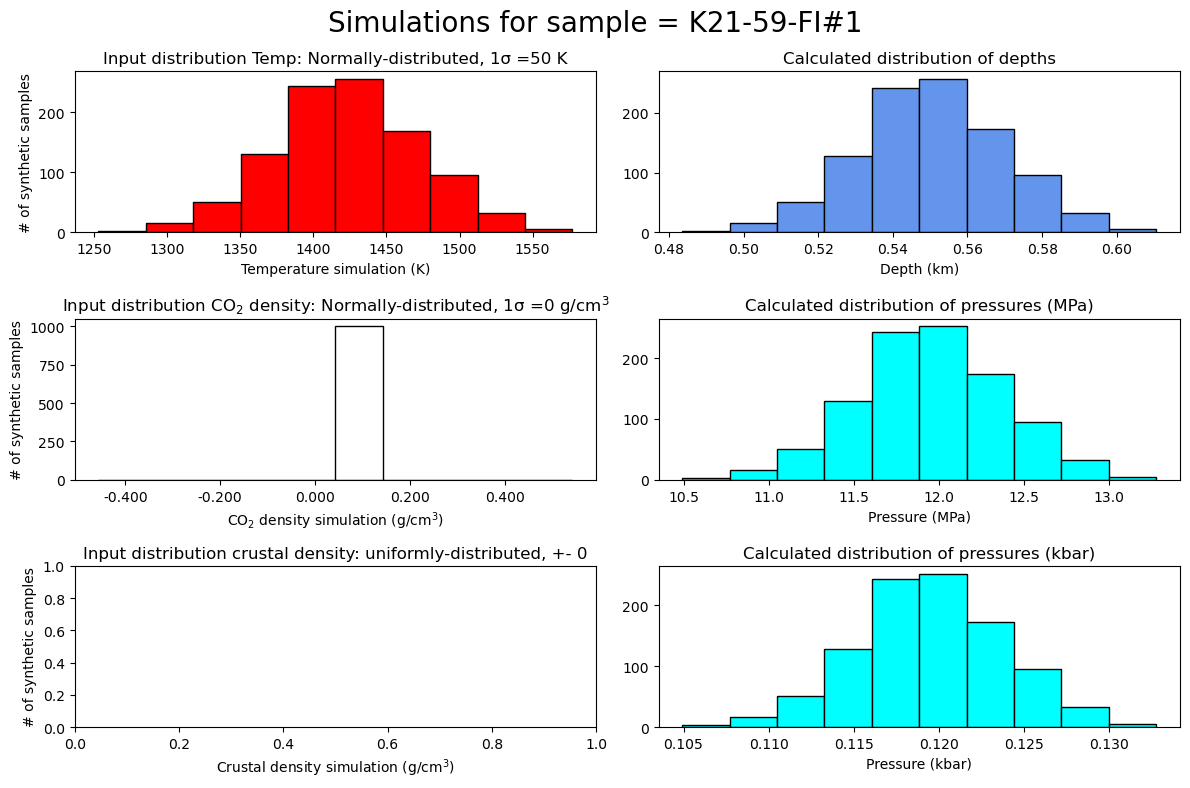

In [30]:
MC_Av_Tonly, MC_All_Tonly, fig=pf.propagate_FI_uncertainty(N_dup=1000,
sample_ID=df['filename_x'],
CO2_dens_gcm3=densities['Preferred D'],
T_K=1150+273.15, error_T_K=50, error_type_T_K='Abs', error_dist_T_K='normal', 
plot_figure=True, model='ryan_lerner' )
MC_Av_Tonly.head()

## You can look at the results here for any given FI

In [31]:
data_FI_59_21=MC_All_Tonly.loc[MC_All_Tonly['Filename']=='K21-59-FI#1']
data_FI_59_21.head()

,Filename,Pressure (kbar),Pressure (MPa),Depth (km),input_crust_dens_kgm3,model,MC_T_K,MC_CO2_dens_gcm3
0,K21-59-FI#1,0.104926,10.492617,0.483599,None,ryan_lerner,1252.934256,0.043246
1,K21-59-FI#1,0.117648,11.764805,0.541628,None,ryan_lerner,1400.867049,0.043246
2,K21-59-FI#1,0.117824,11.782450,0.542432,None,ryan_lerner,1402.919977,0.043246
3,K21-59-FI#1,0.124408,12.440820,0.572410,None,ryan_lerner,1479.538626,0.043246
4,K21-59-FI#1,0.127407,12.740725,0.586055,None,ryan_lerner,1514.452569,0.043246


Text(0, 0.5, '# of simulations')

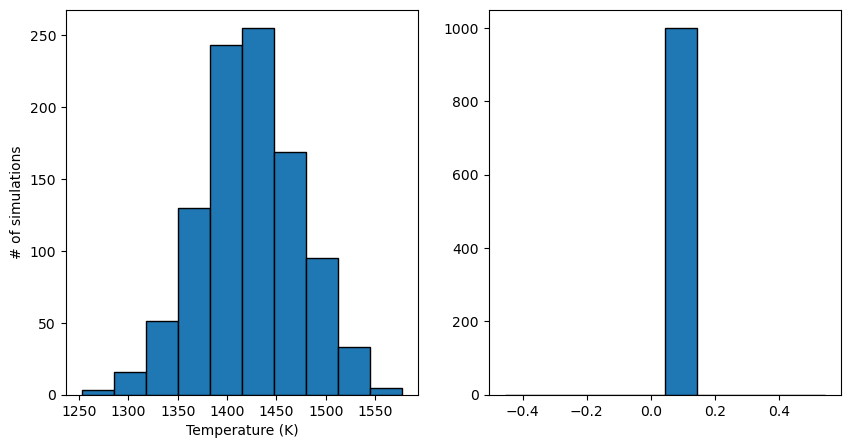

In [32]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
ax1.hist(data_FI_59_21['MC_T_K'], ec='k')
ax2.hist(data_FI_59_21['MC_CO2_dens_gcm3'], ec='k')
ax1.set_xlabel('Temperature (K)')
ax1.set_ylabel('# of simulations')